# Terrestrial water storage anomalies derived form GRACE


Author: Kiana and Iniobong

To use this notebook, the shxarray package should be installed from https://github.com/ITC-Water-Resources/shxarray or from https://pypi.org/project/shxarray/

The data used in this example is from ITSG Level-2 datasets https://www.tugraz.at/institute/ifg/downloads/gravity-field-models/itsg-grace2018#c194128

 
Computing Terrestrial Water Storage change:

Stokes coefficients from the GRACE solutions can be converted to an equivalent water height, but several processing steps are often needed to obtain good results. The steps are described as below:

* Obtain time-anomalies by subtracting a static gravity field from the monthly solutions (more details about the static gravity filed models: https://icgem.gfz-potsdam.de/tom_longtime and https://ggos.org/item/global-gravity-field-models/)

purpose of the exrecise
3 learning outcomes of the tutorial
Water variable from earth observation - tws
2 versions
assign a certain weight to each step

In [1]:
%env OPENBLAS_NUM_THREADS=4

env: OPENBLAS_NUM_THREADS=4


#Optionally enable autoreloading for development purposes. Note that this does not automagically reload the binary extensions
%load_ext autoreload
%autoreload 2
#also supress some warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 01- Load the necessary python modules

In [2]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import gzip
import shxarray

In [3]:
from shxarray.io.icgem import readIcgem

## 02- Convert the data format to zip

Read monthly solutions Stokes coefficients form directory path

In [4]:
def load_icgem_files(datadir):

    gsm = []
    deg1_terms = []
    term_c20 = []
    files = os.listdir(datadir)

    for file in files:
        file_path = os.path.join(datadir, file)
        if "ITSG-Grace2018" in file:
            gsm.append(xr.open_dataset(file_path, engine="icgem"))
        if "c20" in file:
            term_c20.append(xr.open_dataset(file_path, engine="icgem"))
        elif "degree1" in file:
            deg1_terms.append(xr.open_dataset(file_path, engine="icgem"))  ## Depending on the gravitational spherical harmonic model, the engine can be = "gsmv6"

    if deg1_terms and term_c20:
        deg1_cnm = xr.concat(deg1_terms, dim="time").sortby("time")
        c20_cnm = xr.concat(term_c20, dim="time").sortby("time")
        return deg1_cnm, c20_cnm
    else:
        dsgsm = xr.concat(gsm, dim="time")
        dsgsm = dsgsm.sortby('time')
        return dsgsm

In [5]:
datadir = '~/shared/Waterflux/data/ITSG_grace2018/monthly/monthly_n96'

datadir = os.path.expanduser(datadir)

ds = load_icgem_files(datadir)
ds

<xarray.Dataset>
Dimensions:  (time: 162, nm: 9409)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 -2 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 1.0 0.0 0.0 ... 2.452e-10 -2.245e-09 1.527e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 5.098e-11 2.906e-11 2.797e-11
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2007-06

## 03- Apply degree corrections

In [6]:
datadir = os.path.expanduser('~/shared/Waterflux/data/ITSG_grace2018/monthly/monthly_background')
ds_deg1,ds_c20 = load_icgem_files(datadir)

In [7]:
c20 = ds_c20.cnm.sel(n=2, m =0)
ds.cnm.loc[{'n': 2, 'm': 0}]= c20

In [8]:
# deg1_terms = ds_deg1.cnm.sel(n=1)

In [9]:
# for m in [0, 1, -1]:
#     ds.cnm.loc[{'n': 2, 'm': m}] = deg1_terms.sel(m=m)

# 04 -Read the time-invariable static gravity field data

In [10]:
datadir = '~/shared/Waterflux/data/ITSG_grace2018/monthly/static'

datadir = os.path.expanduser(datadir)
name= "ITSG-Grace2018s.gfc"
file_path = os.path.join(datadir, name)
dsstatic = xr.open_dataset(file_path, engine="icgem")
dsstatic

<xarray.Dataset>
Dimensions:  (nm: 40401)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 ... 200 200 200 200 200 200 200 200
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 ... -197 198 -198 199 -199 200 -200
Data variables:
    cnm      (nm) float64 ...
    sigcnm   (nm) float64 ...
Attributes:
    nmaxfile:   200
    nmax:       200
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018s

In [11]:
ds["dcnm"]=ds.cnm-dsstatic.cnm

In [12]:
mask = ds.coords["n"].values != 0
ds_filtered = ds.isel(nm=np.where(mask)[0])
ds_filtered

<xarray.Dataset>
Dimensions:  (time: 162, nm: 9408)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 1 1 1 2 2 2 2 2 3 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 1 -1 0 1 -1 2 -2 0 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 0.0 0.0 0.0 ... 2.452e-10 -2.245e-09 1.527e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 5.098e-11 2.906e-11 2.797e-11
    dcnm     (time, nm) float64 0.0 0.0 0.0 ... -2.963e-11 -1.152e-11 -5.138e-12
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2007-06

nmax=ds.sh.nmax
nmax

# 05- Calculate terrestrial water storage change in spectral domain

In [13]:
datws=ds_filtered.dcnm.sh.tws()
display(datws)

shxarray-INFO: /home/jovyan/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)


<xarray.DataArray 'tws' (time: 162, nm: 9408)>
array([[ 0.        ,  0.        ,  0.        , ..., -0.38059965,
        -0.11055052,  0.13402338],
       [ 0.        ,  0.        ,  0.        , ...,  0.08039811,
        -0.00237433, -0.49129344],
       [ 0.        ,  0.        ,  0.        , ...,  0.07287001,
        -0.04689879, -0.0708848 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.17384523,
        -0.01298814, -0.03466891],
       [ 0.        ,  0.        ,  0.        , ..., -0.02751129,
         0.03004237,  0.06892249],
       [ 0.        ,  0.        ,  0.        , ..., -0.06812388,
        -0.02647713, -0.01181275]])
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 1 1 1 2 2 2 2 2 3 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 1 -1 0 1 -1 2 -2 0 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Attributes:
    units:      m
    long_name:  Total water storage
    gravtype:   tws

# 06- Calculate terrestrial water storage change in spatial domain globally

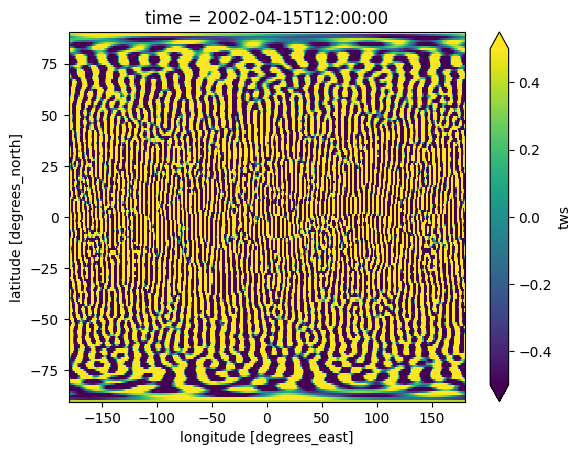

In [14]:
dsgrd=datws.sh.synthesis().to_dataset(name="tws")
islice=0
dsgrd.tws[:,:,islice].plot(vmin=-0.5,vmax=0.5)
dsgrd
lats = dsgrd['lat'].values
lons = dsgrd['lon'].values

# 07- Apply filters

In [15]:
dsgrd["twsgauss"]=datws.sh.filter('Gauss500').sh.synthesis()
# Anisotropic decorrelation filter
dsgrd["twsddk"]=datws.sh.filter('DDK5').sh.synthesis()

#dr_tm=datws.sh.filter('DDK8')
#dsgrd["twsddk"]=dr_tm.sh.synthesis(lon=[43,45],lat=[1,3])

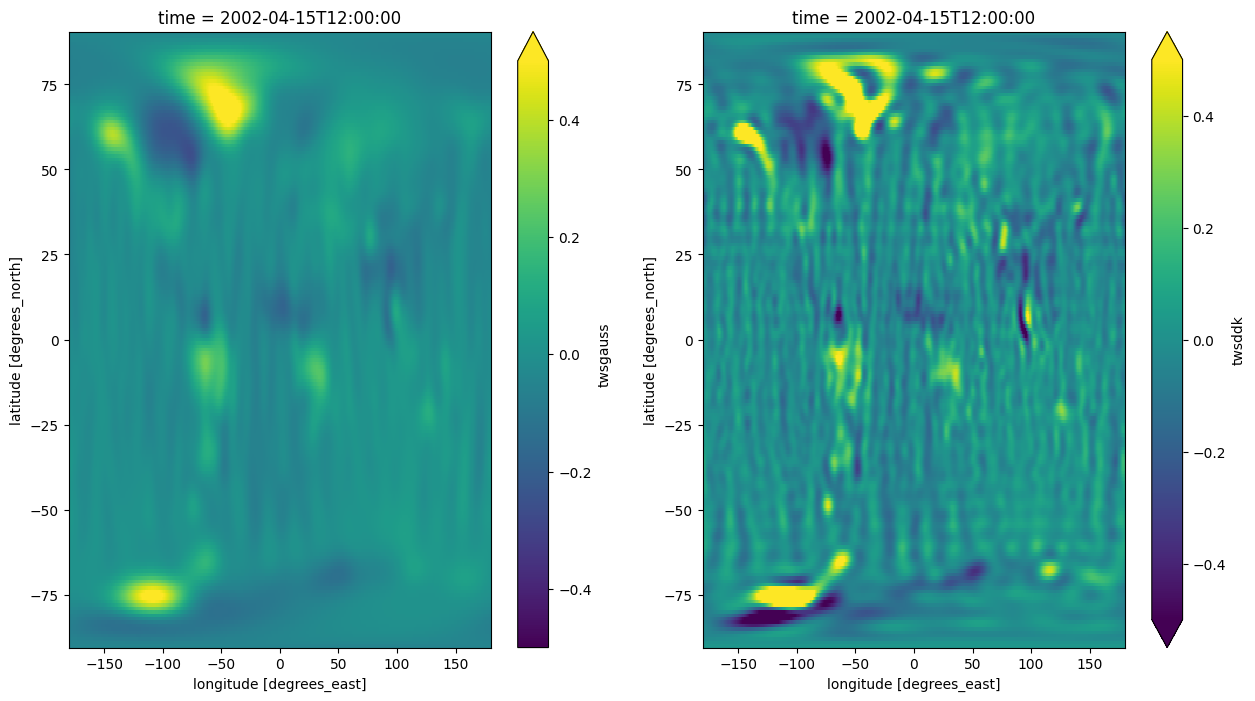

In [16]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))
vmin=-0.5
vmax=0.5

islice=0
dsgrd.twsgauss[:,:,islice].plot(ax=axs[0],vmin=vmin,vmax=vmax)
dsgrd.twsddk[:,:,islice].plot(ax=axs[1],vmin=vmin,vmax=vmax)

## Other Filters??